## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

## 1. Carga datos y representa la serie

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from math import sqrt



In [43]:
# Cargamos el dataset
df = pd.read_csv('data/AirPassengers.csv')


In [44]:
df

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [46]:
df.describe()

,value
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [47]:
# convertir en datatime
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)


date     datetime64[ns]
value             int64
dtype: object


In [48]:
# Extraer año
df['year'] = df['date'].dt.year

# Extraer mes
df['month'] = df['date'].dt.month

# Extraer día
df['day'] = df['date'].dt.day

# Extraer día de la semana (0 = lunes, 6 = domingo)
df['weekday'] = df['date'].dt.weekday



In [49]:
df


,date,value,year,month,day,weekday
0,1949-01-01,112,1949,1,1,5
1,1949-02-01,118,1949,2,1,1
2,1949-03-01,132,1949,3,1,1
3,1949-04-01,129,1949,4,1,4
4,1949-05-01,121,1949,5,1,6
...,...,...,...,...,...,...
139,1960-08-01,606,1960,8,1,0
140,1960-09-01,508,1960,9,1,3
141,1960-10-01,461,1960,10,1,5
142,1960-11-01,390,1960,11,1,1


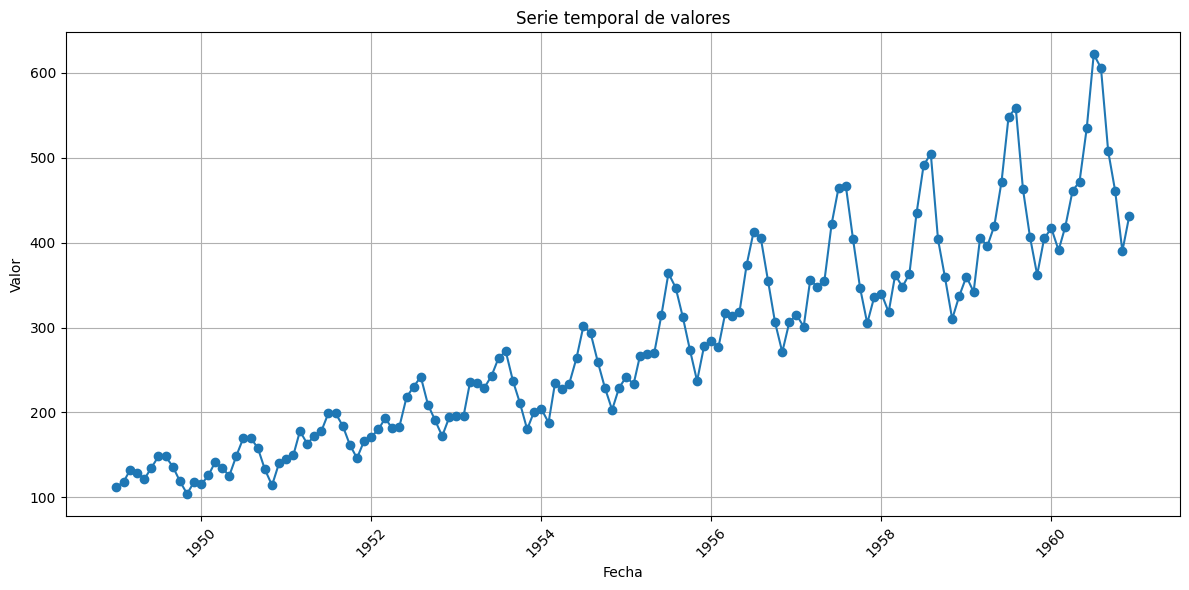

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Tamaño del gráfico
plt.plot(df['date'], df['value'], marker='o', linestyle='-')

plt.title('Serie temporal de valores')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.xticks(rotation=45)  # Rota etiquetas para mejor lectura
plt.tight_layout()
plt.show()


- La gráfica muestra  un patrón estacional que se repite cada 12 meses.

#### Descomposición de la serie temporal con seasonal_decompose de statsmodels:
- Este análisis separa la serie en:
- Tendencia (Trend)
- Estacionalidad (Seasonal)
- Ruido aleatorio (Residual)
- period=12 se usa si crees que hay un patrón anual con datos mensuales. Cambia este número según la frecuencia de tu serie.

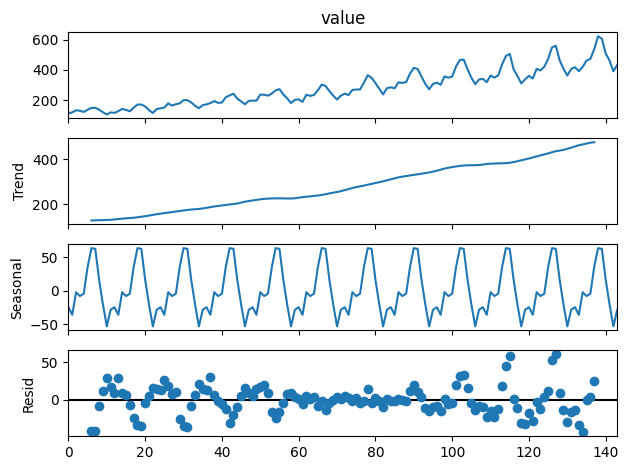

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Asegúrate de que el índice es datetime y esté en orden
df = df.sort_index()
result = seasonal_decompose(df['value'], model='additive', period=12)  # Cambia period si es otra frecuencia

result.plot()
plt.show()


## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

In [58]:
# Alternativa manteniendo estructura de DataFrame
data['rolling_mean'] = data['passengers'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['passengers'], label='Datos originales')
plt.plot(data['rolling_mean'], color='red', label='Media móvil (12 meses)')
plt.title('Pasajeros con media móvil anual')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'data' is not defined

## 3. Comprueba de manera estadística si la serie es o no stationary.

## 4. Aplica una transformación logarítmica

## 5. Divide en train y test. Guarda 20 muestras para test.

## 6. Crea tu primer modelo ARIMA

## 7. Representa en una gráfica los datos de test y tus predicciones.

## 8. Prueba otros modelos, a ver qué performance presentan.